In [301]:
import numpy as np
from tensorflow import keras
random_seed = 233
np.random.seed()
Network = 'CNN'

# load data

In [302]:
train_segments, train_labels = np.load("train_segments.npy"), np.load("train_labels.npy")
test_segments, test_labels = np.load("test_segments.npy"), np.load("test_labels.npy")

print("Original train size:", train_segments.shape, "test size:", test_segments.shape)


Original train size: (11146, 25) test size: (2736, 25)


# prepare data

In [303]:
from sklearn.model_selection import train_test_split
nb_classes = len(np.unique(test_labels))
batch_size = min(train_segments.shape[0]/10, 16)
    
    
Y_train = keras.utils.to_categorical(train_labels, nb_classes)
Y_test = keras.utils.to_categorical(test_labels, nb_classes)
    
x_train = train_segments.reshape(train_segments.shape + (1,))
x_test = test_segments.reshape(test_segments.shape + (1,))
x_train, x_val, Y_train, Y_val  = train_test_split(x_train, Y_train, test_size=0.20, random_state=1)

print(f"train.shape{x_train.shape},{Y_train.shape}")
print(f"val.shape{x_val.shape},{Y_val.shape}")
print(f"test.shape{x_test.shape},{Y_test.shape}")

train.shape(8916, 25, 1),(8916, 5)
val.shape(2230, 25, 1),(2230, 5)
test.shape(2736, 25, 1),(2736, 5)


# CNN

In [318]:

from keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten,InputLayer,BatchNormalization,Activation,GlobalAveragePooling1D,Input,Conv2D,MaxPooling2D,AveragePooling1D
from tensorflow.keras.regularizers import l1, l2

def cnn1d(input_shape, nb_classes):
    # 8801
    input_tensor = Input(shape=input_shape)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    # x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    #Pooling1D layer
    x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    x = Dense(nb_classes, activation='softmax')(x)
    
    model = keras.Model(input_tensor, x)
    return model

def cnn1d_2(input_shape, nb_classes):
    input_tensor = Input(shape=input_shape)
    #coverlution layer
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    # x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
 
    
    #Pooling1D layer
    x = GlobalAveragePooling1D()(x)
    # x = Flatten()(x)
    x = Dense(nb_classes, activation='softmax')(x)
    
    model = keras.Model(input_tensor, x)
    return model


model = cnn1d_2(x_train.shape[1:],nb_classes)



adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                       decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
                loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

nb_epochs = 1500
batch_size = 16
callbacks = [
# keras.callbacks.ModelCheckpoint(
#     "best_model.keras", save_best_only=True, monitor="val_loss"
# ),
keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, min_lr=1e-6
),
keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]

hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
        verbose=1, callbacks = callbacks,validation_data=(x_val, Y_val))

    
from datetime import datetime
current_time = datetime.now()
formatted_time = current_time.strftime("%m%d_%H%M%S")
import pandas as pd
model.save(f'./{Network}/{formatted_time}/Net.h5')
log = pd.DataFrame(hist.history)
log.to_csv(f'./{Network}/{formatted_time}/Accuracy.csv')




e:\Anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 25, 1)]           0         
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 25, 128)           1024      
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 25, 64)            41024     
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 25, 64)            12352     
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 25, 64)            12352     
_________________________________________________________________
global_average_pooling1d_61  (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 325

In [319]:
model.summary()
X = x_train
for layer in model.layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 25, 1)]           0         
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 25, 128)           1024      
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 25, 64)            41024     
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 25, 64)            12352     
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 25, 64)            12352     
_________________________________________________________________
global_average_pooling1d_61  (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 325

# result

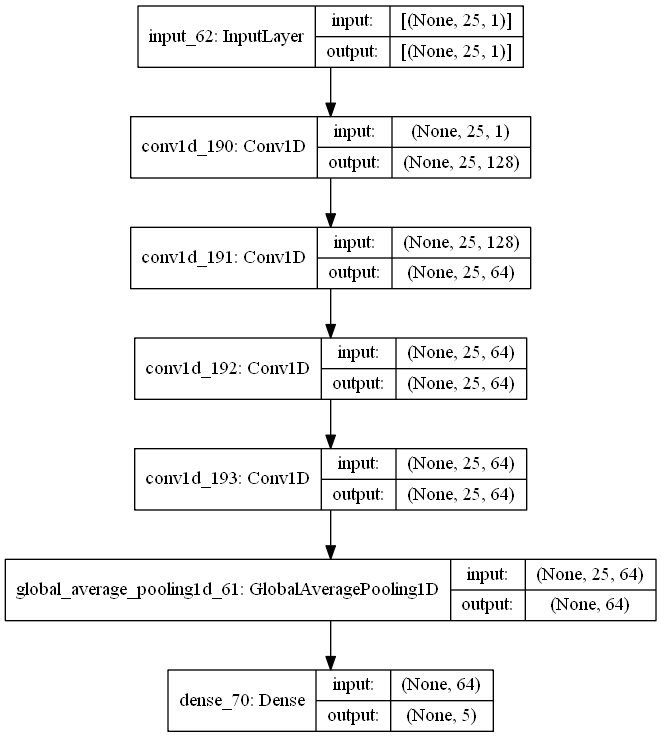

In [320]:
import pydot
from keras.utils.vis_utils import plot_model

plot_model(model,to_file=f"./{Network}/{formatted_time}/model.png",show_shapes=True)

In [321]:
test_loss, test_accuracy = model.evaluate(x_test, Y_test)

86/86 [==============================] - 0s 3ms/step - loss: 0.3389 - accuracy: 0.8772


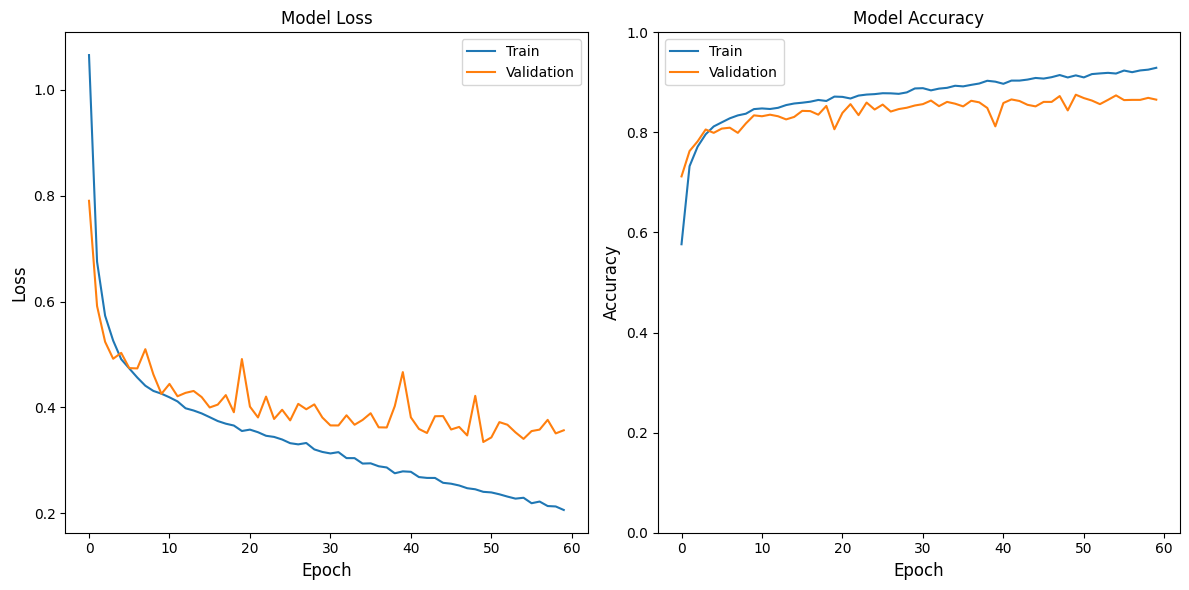

In [322]:
import matplotlib.pyplot as plt
hist = pd.read_csv(f'./{Network}/{formatted_time}/Accuracy.csv')
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Validation"], loc="best")

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Validation"], loc="best")

plt.tight_layout() 

plt.savefig(f'./{Network}/{formatted_time}/Accuracy.png')

# plot confusion matrix

In [316]:
from sklearn import metrics
def plot_confusionMatrix(cM, labels,title=Network):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:}'.format(cmNormalized[predicted,real]),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig( f'./{Network}/{formatted_time}/ConfusionMatrix.png')
def evaluate_model(groundTruthClass,predictedClass):
    accuracy = metrics.accuracy_score(groundTruthClass,predictedClass)
    print('Accuracy:',accuracy*100,'%')
    precision = metrics.precision_score(groundTruthClass,predictedClass,average='macro')
    print('Precision:',precision*100,'%')
    recall = metrics.recall_score(groundTruthClass,predictedClass,average='macro')
    print('Recall:',recall*100,'%')
    f1 = metrics.f1_score(groundTruthClass,predictedClass,average='macro')
    print('F1 score:',f1*100,'%')

86/86 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       542
         1.0       0.79      0.73      0.76       565
         2.0       0.87      0.86      0.86       561
         3.0       0.82      0.91      0.86       524
         4.0       0.88      0.85      0.86       544

    accuracy                           0.86      2736
   macro avg       0.86      0.86      0.86      2736
weighted avg       0.86      0.86      0.86      2736

[[529  13   0   0   0]
 [ 22 411  46  64  22]
 [  2  32 483   7  37]
 [  3  35   6 476   4]
 [  0  26  23  34 461]]
Accuracy for each class is given below.
Sitting     : 97.6 %
Stretching  : 72.74 %
Walking     : 86.1 %
Jumping     : 90.84 %
Running     : 84.74 %


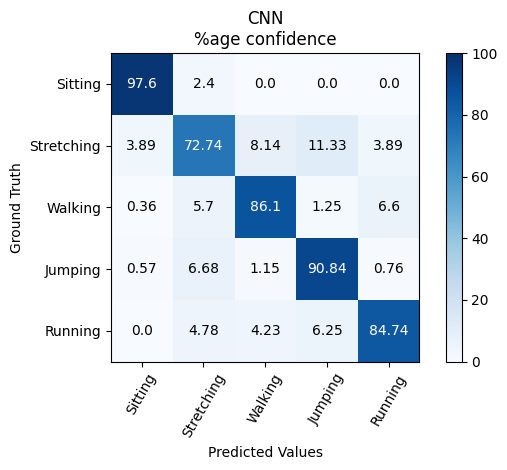

In [317]:
# defining the class labels
# model = keras.models.load_model(f'./{Network}/1229_041035/Net.h5')
labels = [ 'Sitting', 'Stretching', 'Walking', 'Jumping', 'Running']
# predicting the classes
predictions = model.predict(x_test,verbose=1)
# getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((predictions.shape[0]))
groundTruthClass = np.zeros((Y_test.shape[0]))
for instance in range (Y_test.shape[0]):
    predictedClass[instance] = np.argmax(predictions[instance])
    groundTruthClass[instance] = np.argmax(Y_test[instance])
# obtaining a confusion matrix  
clr = metrics.classification_report(groundTruthClass,predictedClass)
print(clr)
cm = metrics.confusion_matrix(groundTruthClass,predictedClass)
print(cm)
# plotting the confusion matrix
plot_confusionMatrix(cm, labels)